In [77]:
import matplotlib.pyplot as plt
import astricaltools as at
import numpy as np
import pandas as pd
import scipy.stats as sc
from astropy import stats
import astropy.units as u
from astropy.io import fits
from astropy.table import vstack, Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, Angle

In [78]:
file_numbers = range(1, 10)  # da 001 a 009
base_path = "astri_{:03d}_43_009_00002_R_201023_004_0201_SEB.lv0"  # pattern del nome file

dfs = []  # lista per accumulare i DataFrame
print("\n")
for i in file_numbers:
    filename = base_path.format(i)
    print(f"{filename}")

    with at.io.fits.AstriFits(filename) as hdul:
        data = hdul[1].data

        # Conversione dei campi
        time_ns = data["TIME_NS"].byteswap().newbyteorder().astype(np.int64)
        time_s  = data["TIME_S"].byteswap().newbyteorder().astype(np.int64)
        event   = data["EVTNUM"].byteswap().newbyteorder().astype(np.int64)
        mcrun   = data["MCRUNNUM"].byteswap().newbyteorder().astype(np.int64)
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
        hg, lg, ttp = hdul.get_data('events', ['hi', 'lo', 'ttp'])
        time_abs = time_s * 10**9 + time_ns  # tempo assoluto in ns
            #creo il dataframe
        df = pd.DataFrame({
                "TIME_NS": time_ns,
                "TIME_S": time_s,
                "TIME_ABS": time_abs,
                "EVENT": event,
                "MCRUN": mcrun,
                "TEL_ID": i,
                "HG": list(hg),             
                "LG": list(lg),
                "TTP": list(ttp),
            })

        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all_sorted= df_all.sort_values(by="TIME_ABS").reset_index(drop=True)
df_all_sorted['shape']= df_all_sorted['HG'].apply(np.sum).to_numpy()
print(df_all.head())
print(df_all_sorted.head())





astri_001_43_009_00002_R_201023_004_0201_SEB.lv0
astri_002_43_009_00002_R_201023_004_0201_SEB.lv0
astri_003_43_009_00002_R_201023_004_0201_SEB.lv0
astri_004_43_009_00002_R_201023_004_0201_SEB.lv0
astri_005_43_009_00002_R_201023_004_0201_SEB.lv0
astri_006_43_009_00002_R_201023_004_0201_SEB.lv0
astri_007_43_009_00002_R_201023_004_0201_SEB.lv0
astri_008_43_009_00002_R_201023_004_0201_SEB.lv0
astri_009_43_009_00002_R_201023_004_0201_SEB.lv0
    TIME_NS  TIME_S  TIME_ABS  EVENT   MCRUN  TEL_ID  \
0  15104575       0  15104575   2217  263211       1   
1  25307129       0  25307129   7009  263211       1   
2  28859186       0  28859186   2217  263212       1   
3  32680807       0  32680807   4213  263212       1   
4  35023796       0  35023796    417  263213       1   

                                                  HG  \
0  [[2158, 2264, 2118, 2251, 2150, 2144, 2247, 22...   
1  [[2251, 2145, 2137, 2122, 2236, 2138, 2146, 22...   
2  [[2107, 2316, 2213, 2026, 2181, 2110, 2212, 21...

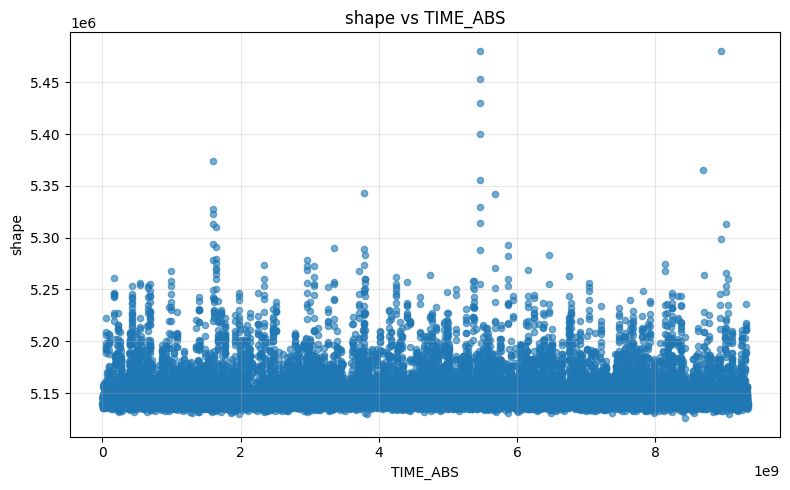

Index(['TIME_NS', 'TIME_S', 'TIME_ABS', 'EVENT', 'MCRUN', 'TEL_ID', 'HG', 'LG',
       'TTP', 'shape'],
      dtype='object')

In [ ]:
plt.figure(figsize=(8, 5))

plt.scatter(df_all_sorted["TIME_ABS"],df_all_sorted["shape"],s=20,alpha=0.6)
plt.xlabel("TIME_ABS")
plt.ylabel("shape")
plt.title("shape vs TIME_ABS")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


/home/matfra/miniconda3/envs/astrienv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Eventi selezionati: 4


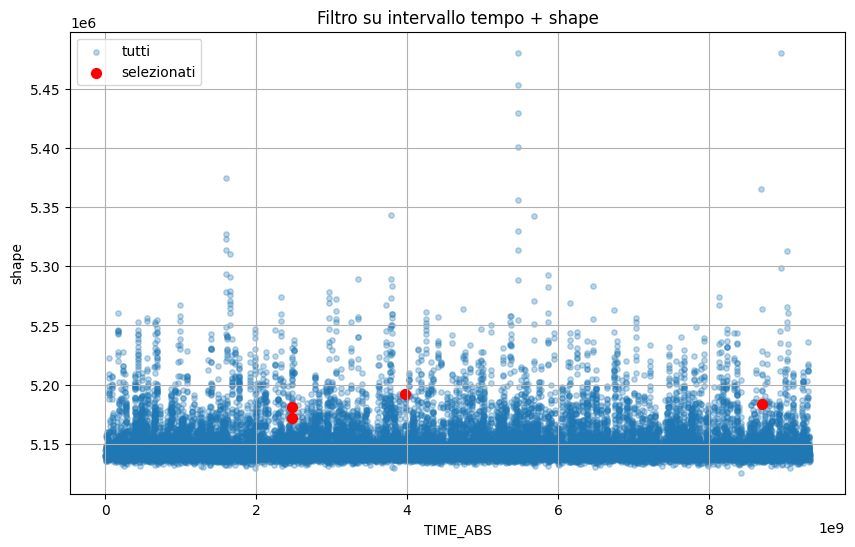

         TIME_NS  TIME_S    TIME_ABS  EVENT   MCRUN  TEL_ID  \
6794   473242766       2  2473242766   7008  263458       9   
6796   473242821       2  2473242821   7009  263458       1   
10814  976368509       3  3976368509   7500  263696       2   
23781  705483731       8  8705483731   2217  266345       9   

                                                      HG  \
6794   [[2226, 2107, 2187, 2060, 2179, 2245, 2185, 21...   
6796   [[2168, 2214, 2208, 2267, 2125, 2084, 2213, 22...   
10814  [[2257, 2214, 2164, 2281, 2130, 2182, 2117, 22...   
23781  [[2153, 2115, 2196, 2188, 2112, 2185, 2138, 22...   

                                                      LG  \
6794   [[2133, 2127, 2131, 2125, 2131, 2134, 2131, 21...   
6796   [[2130, 2132, 2132, 2135, 2128, 2126, 2132, 21...   
10814  [[2135, 2132, 2130, 2136, 2128, 2131, 2127, 21...   
23781  [[2129, 2127, 2131, 2131, 2127, 2131, 2129, 21...   

                                                     TTP    shape   delta_t  \
679

In [93]:

# ======= SOGLIE ======    
shape_cut = 5.16e6   

# ================================================
df_all_sorted["logdt"] = np.log10(df_all_sorted["TIME_ABS"].diff().abs())
df_all_sorted["EVENT_prev"] = df_all_sorted["EVENT"].shift(1)
df_sel = df_all_sorted[ (df_all_sorted["logdt"] < 3) & (df_all_sorted["shape"] >= shape_cut)
                        & (df_all_sorted["EVENT"] != df_all_sorted["EVENT_prev"])]

print("Eventi selezionati:", len(df_sel))

# ======= PLOT DEI PUNTI SELEZIONATI =======

plt.figure(figsize=(10,6))
plt.scatter(df_all_sorted["TIME_ABS"], df_all_sorted["shape"], 
            s=15, alpha=0.3, label="tutti")

plt.scatter(df_sel["TIME_ABS"], df_sel["shape"], 
            s=50, color="red", label="selezionati")

plt.xlabel("TIME_ABS")
plt.ylabel("shape")
plt.title("Filtro su intervallo tempo + shape")
plt.legend()
plt.grid(True)
plt.show()
df_sel=df_sel.sort_values(by="TIME_ABS")
print(df_sel)

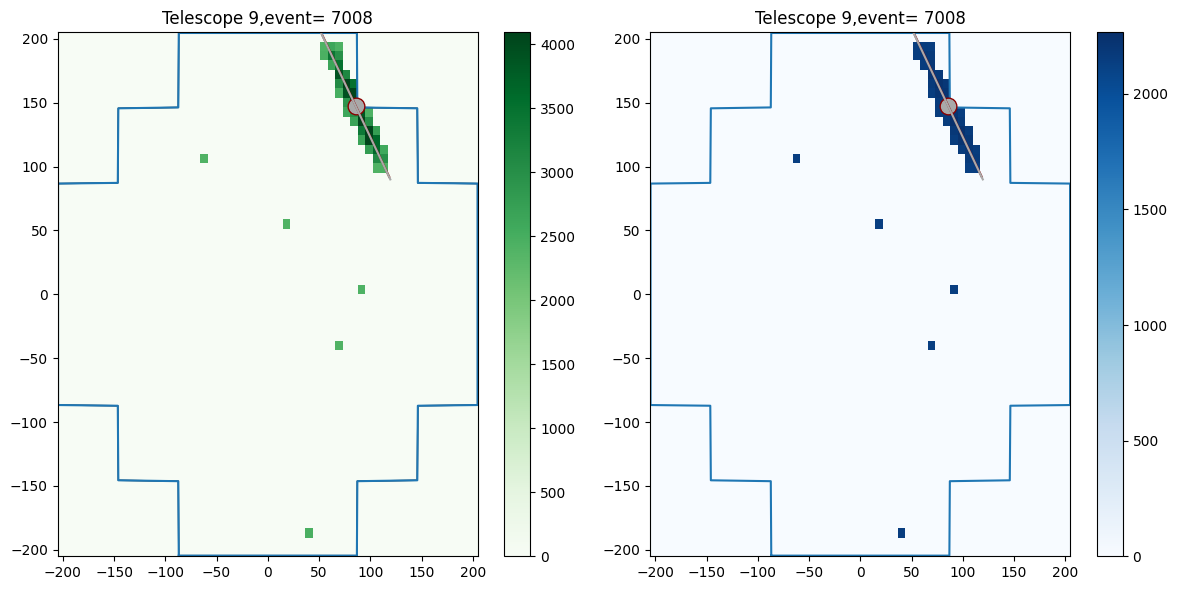

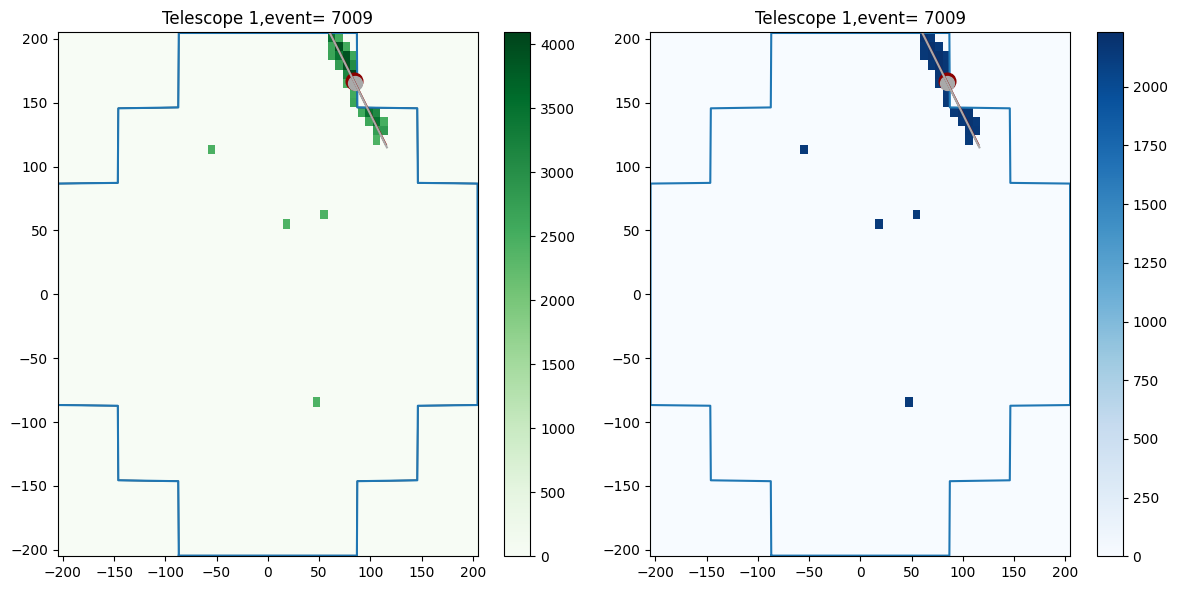

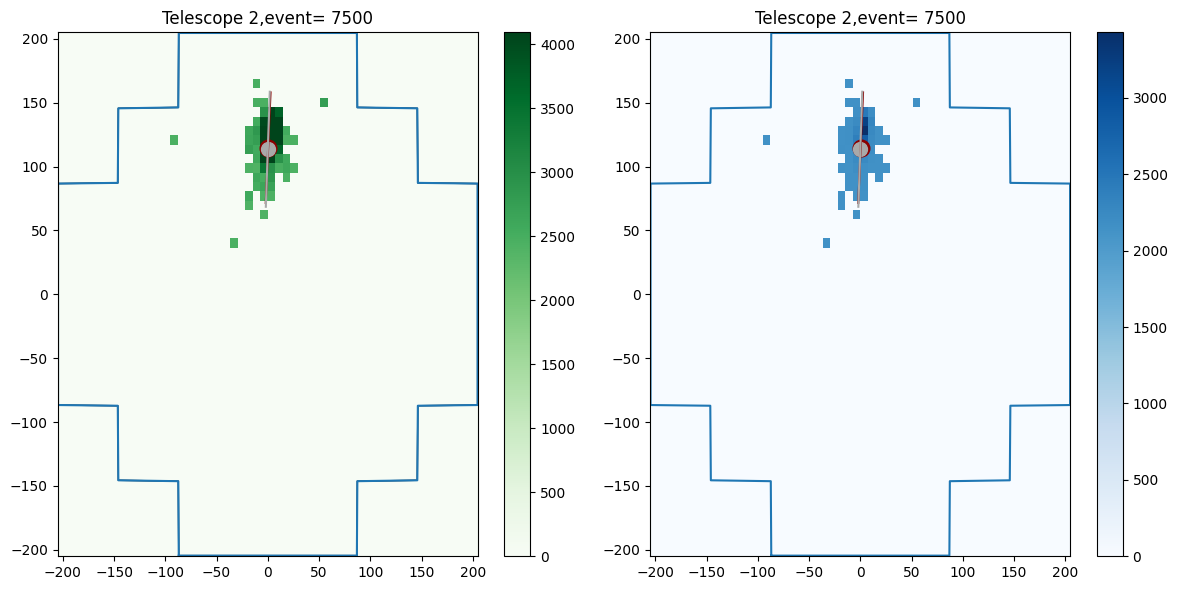

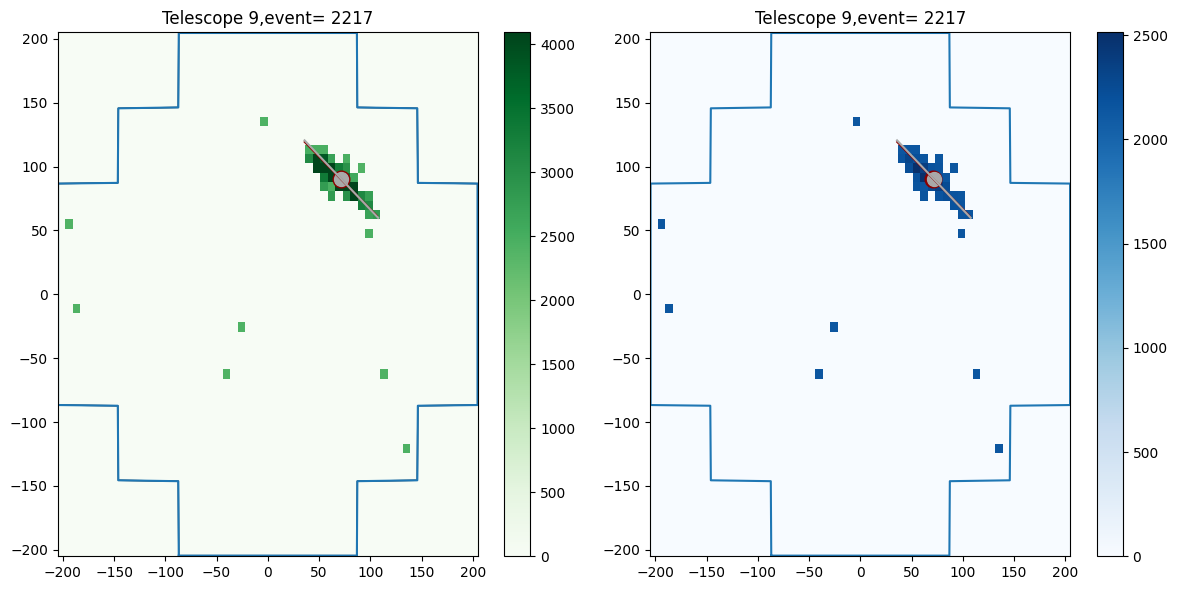

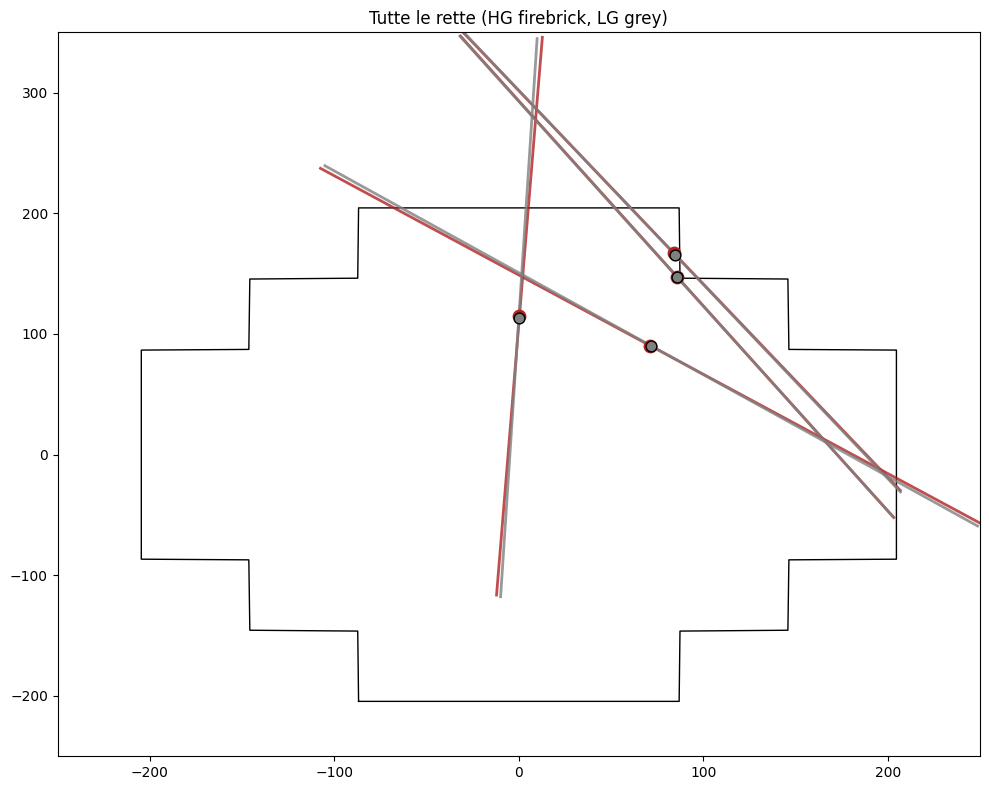

HG rette: 4
LG rette: 4
{'p0': array([ 85.81715863, 147.3866535 ]), 'd': array([-0.50732319,  0.86175587]), 'tel': 9}
         TIME_NS  TIME_S    TIME_ABS  EVENT   MCRUN  TEL_ID  \
6794   473242766       2  2473242766   7008  263458       9   
6796   473242821       2  2473242821   7009  263458       1   
10814  976368509       3  3976368509   7500  263696       2   
23781  705483731       8  8705483731   2217  266345       9   

                                                      HG  \
6794   [[2226, 2107, 2187, 2060, 2179, 2245, 2185, 21...   
6796   [[2168, 2214, 2208, 2267, 2125, 2084, 2213, 22...   
10814  [[2257, 2214, 2164, 2281, 2130, 2182, 2117, 22...   
23781  [[2153, 2115, 2196, 2188, 2112, 2185, 2138, 22...   

                                                      LG  \
6794   [[2133, 2127, 2131, 2125, 2131, 2134, 2131, 21...   
6796   [[2130, 2132, 2132, 2135, 2128, 2126, 2132, 21...   
10814  [[2135, 2132, 2130, 2136, 2128, 2131, 2127, 21...   
23781  [[2129, 2127, 2131

In [101]:
xfp, yfp = at.utils.camera.get_xy_footprint()
y_pix, x_pix = at.utils.camera.get_pixels_position_matrix().T

x_pix = at.reshape(x_pix)
y_pix = at.reshape(y_pix)

rette_hg = []
rette_lg = []

# ============================================================
#   calcolo, sigma clip, istogrammi, salvataggio rette

for iv in range(len(df_sel)):

    itel = df_sel["TEL_ID"].iloc[iv]
    hgev = np.array(df_sel['HG'])[iv]
    lgev = np.array(df_sel['LG'])[iv]
    ttpev = np.array(df_sel['TTP'])[iv]

    # mask di pixel buoni
    pxmask = (hgev > 2400) & (ttpev < 255)

    # --------------------------
    # SIGMA-CLIPPING
    
    xx = x_pix[pxmask].flatten()
    yy = y_pix[pxmask].flatten()
    w_hg = hgev[pxmask].flatten()
    w_lg = lgev[pxmask].flatten()

    mx0 = np.average(xx, weights=w_hg)
    my0 = np.average(yy, weights=w_hg)

    r = np.sqrt((xx - mx0)**2 + (yy - my0)**2)

    r_clip, low, high = sc.sigmaclip(r, low=3.0, high=3.0)
    keep = (r >= low) & (r <= high)

    xx_sc = xx[keep]
    yy_sc = yy[keep]
    w_hg_sc = w_hg[keep]
    w_lg_sc = w_lg[keep]
    # --------------------------

    # ---------- centroidi ----------
    meanx_hg = np.average(xx_sc, weights=w_hg_sc)
    meany_hg = np.average(yy_sc, weights=w_hg_sc)

    meanx_lg = np.average(xx_sc, weights=w_lg_sc)
    meany_lg = np.average(yy_sc, weights=w_lg_sc)

    # ---------- covarianze ----------
    cov_hg = np.cov([xx_sc, yy_sc], aweights=w_hg_sc)
    cov_lg = np.cov([xx_sc, yy_sc], aweights=w_lg_sc)

    # ---------- direzione ellisse ----------
    l1_hg = (cov_hg[0,0] + cov_hg[1,1])/2 + np.sqrt(((cov_hg[0,0]-cov_hg[1,1])/2)**2 + cov_hg[0,1]**2)
    l1_lg = (cov_lg[0,0] + cov_lg[1,1])/2 + np.sqrt(((cov_lg[0,0]-cov_lg[1,1])/2)**2 + cov_lg[0,1]**2)

    theta_hg = np.arctan2(l1_hg - cov_hg[0,0], cov_hg[0,1])
    theta_lg = np.arctan2(l1_lg - cov_lg[0,0], cov_lg[0,1])

    # ---------- salvo le rette ----------
    rette_hg.append({
        "p0": np.array([meanx_hg, meany_hg]),
        "d":  np.array([np.cos(theta_hg), np.sin(theta_hg)]),
        "tel": itel
    })

    rette_lg.append({
        "p0": np.array([meanx_lg, meany_lg]),
        "d":  np.array([np.cos(theta_lg), np.sin(theta_lg)]),
        "tel": itel
    })



    fig, ax = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)
    ax[0].plot(xfp, yfp, 'k-', linewidth=1)
    hl = ax[0].hist2d(xx, yy, weights=w_hg,
                      range=((-205, 205), (-205, 205)),
                      bins=7*8, cmap='Greens')

    hh = ax[1].hist2d(xx, yy, weights=w_lg,
                      range=((-205, 205), (-205, 205)),
                      bins=7*8, cmap='Blues')

    fig.colorbar(hl[3], ax=ax[0])
    fig.colorbar(hh[3], ax=ax[1])

    for ai in ax:
        ai.plot(xfp, yfp)
        ai.set_title(f"Telescope {itel},event= {df_sel['EVENT'].iloc[iv] }")
        ai.plot(meanx_hg, meany_hg, 'o', markersize=12, color='darkred')
        ai.plot(meanx_lg, meany_lg, 'o', markersize=10, color='darkgrey')

        # rette
        ai.plot([meanx_hg - 2*np.sqrt(l1_hg)*np.cos(theta_hg),
                 meanx_hg + 2*np.sqrt(l1_hg)*np.cos(theta_hg)],
                [meany_hg - 2*np.sqrt(l1_hg)*np.sin(theta_hg),
                 meany_hg + 2*np.sqrt(l1_hg)*np.sin(theta_hg)],
                '-', color='darkred')

        ai.plot([meanx_lg - 2*np.sqrt(l1_lg)*np.cos(theta_lg),
                 meanx_lg + 2*np.sqrt(l1_lg)*np.cos(theta_lg)],
                [meany_lg - 2*np.sqrt(l1_lg)*np.sin(theta_lg),
                 meany_lg + 2*np.sqrt(l1_lg)*np.sin(theta_lg)],
                '-', color='darkgrey')

    plt.show()

# ============================================================
#   tutte le rette insieme

fig, ax = plt.subplots(figsize=(10, 8))
# footprint camera 
ax.plot(xfp, yfp, 'k-', linewidth=1)

# calcolo lunghezza estetica delle rette
xmin, xmax = np.min(xfp), np.max(xfp)
ymin, ymax = np.min(yfp), np.max(yfp)
diag = np.sqrt((xmax - xmin)**2 + (ymax - ymin)**2)
L = 0.40 * diag

# centroidi e rette HG
for r in rette_hg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide HG (punto rosso grande)
    ax.scatter(p0[0], p0[1], s=80, color="firebrick", zorder=5)

    # retta lunga HG (firebrick)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="firebrick", linewidth=2, alpha=0.8)

#  centroidi e rette LG 
for r in rette_lg:
    p0 = r["p0"]
    d  = r["d"]

    # centroide LG (punto grigio più piccolo con bordo nero)
    ax.scatter(p0[0], p0[1], s=60, color="grey", edgecolor="black", zorder=5)

    # retta lunga LG (grey)
    x1 = p0[0] - L * d[0]
    y1 = p0[1] - L * d[1]
    x2 = p0[0] + L * d[0]
    y2 = p0[1] + L * d[1]
    ax.plot([x1, x2], [y1, y2], color="grey", linewidth=2, alpha=0.8)

ax.set_title("Tutte le rette (HG firebrick, LG grey)")
ax.set_xlim(-250,250 )
ax.set_ylim(-250,350)

plt.tight_layout()
plt.show()

print("HG rette:", len(rette_hg))
print("LG rette:", len(rette_lg))
print(rette_hg[0])
print(df_sel)